<h1><center>Music Genre Classification</center></h1>

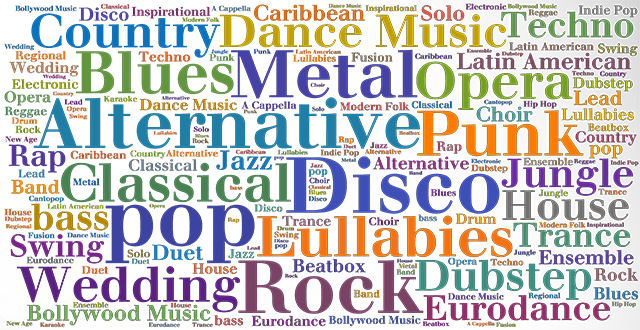

In [19]:
from IPython.display import Image
Image(filename='Music genres.png',width=1000)

## Problem Statement

1. To build a model which classifies music into its respective genre.
2. To compare the accuracies of the pre-existing and newly built models and draw the necessary conclusions.

## About the Dataset

To read the dataset we have used librosa library which only read files <1Mb and one file is greater than the size giving error due to which we have ignored it. The dataset contains the following genres, the keys being the prediction targets
    
    0: "disco",
    1: "metal",
    2: "reggae",
    3: "blues",
    4: "rock",
    5: "classical",
    6: "jazz",
    7: "hiphop",
    8: "country",
    9: "pop"

**Kaggle Link: https://www.kaggle.com/andradaolteanu/gtzan-dataset-music-genre-classification**

## Importing the Libraries

In [41]:
import os
import librosa
import math
import json 
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import librosa.display
import IPython.display as ipd
from scipy.io import wavfile as wav
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
import tensorflow.keras as keras
from sklearn.model_selection import train_test_split
import splitfolders
from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.models import Model

In [21]:
print(list(os.listdir(f'./genres_original/')))

['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']


# Explore Audio Data

In [22]:
def plot_sound(path):
    plt.figure(figsize=(14, 5))
    x, sr = librosa.load(path)
    print("length {}, sample-rate {}".format(x.shape, sr))
    librosa.display.waveplot(x, sr=sr)
    
    return x

length (661794,), sample-rate 22050


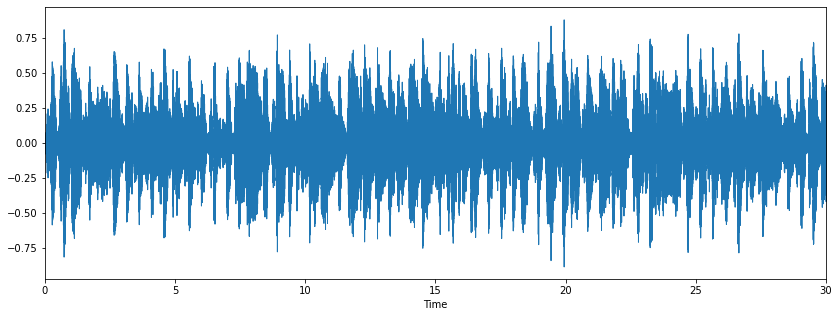

In [23]:
blues_path = './genres_original/blues/blues.00000.wav'
blues_audio = plot_sound(blues_path)
ipd.Audio(blues_path)

# Plot Spectrogram

A spectrogram is a visual way of representing the signal loudness, of a signal over time at various frequencies present in a particular waveform. Not only can one see whether there is more or less energy at, for example, 2 Hz vs 10 Hz, but one can also see how energy levels vary over time.

In [24]:
x, sr = librosa.load(blues_path)

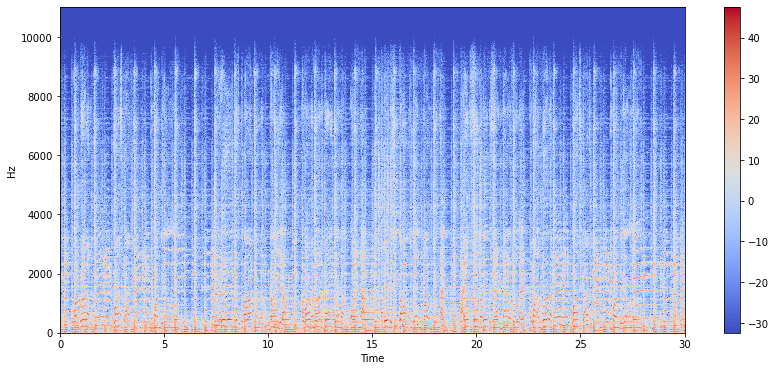

In [25]:
X = librosa.stft(x)
Xdb = librosa.amplitude_to_db(abs(X))
plt.figure(figsize=(14, 6))
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
plt.colorbar()

The vertical axis represents frequencies (from 0 to 10kHz), and the horizontal axis represents the time of the clip.

# Load Dataset

In [26]:
dataset_path = r"./genres_original"
json_path = r"data.json"
SAMPLE_RATE = 22050
DURATION = 30
SAMPLES_PER_TRACK = SAMPLE_RATE * DURATION

In [27]:
def save_mfcc(dataset_path, json_path, n_mfcc=13, n_fft=2048,
             hop_length=512, num_segments=5):
    # Data storage dictionary
    data = {
        "mapping": [],
        "mfcc": [],
        "labels": [],
    }
    samples_ps = int(SAMPLES_PER_TRACK/num_segments) # ps = per segment
    expected_vects_ps = math.ceil(samples_ps/hop_length)
    
    # loop through all the genres
    for i, (dirpath, dirnames, filenames) in enumerate(os.walk(dataset_path)):
        # ensuring not at root
        if dirpath is not dataset_path:
            # save the semantic label
            dirpath_comp = dirpath.split("/")
            semantic_label = dirpath_comp[-1]
            data["mapping"].append(semantic_label)
            print(f"Processing: {semantic_label}")
            
            # process files for specific genre
            for f in filenames:
                if(f==str("jazz.00054.wav")):
                    # As librosa only read files <1Mb
                    continue
                else:
                    # load audio file
                    file_path = os.path.join(dirpath, f)
                    signal,sr = librosa.load(file_path,sr=SAMPLE_RATE)
                    for s in range(num_segments):
                        start_sample = samples_ps * s
                        finish_sample = start_sample + samples_ps

                        mfcc = librosa.feature.mfcc(signal[start_sample:finish_sample],
                                                    sr = sr,
                                                    n_fft = n_fft,
                                                    n_mfcc = n_mfcc,
                                                    hop_length = hop_length)

                        mfcc = mfcc.T

                        # store mfcc if it has expected length 
                        if len(mfcc)==expected_vects_ps:
                            data["mfcc"].append(mfcc.tolist())
                            data["labels"].append(i-1)
                            print(f"{file_path}, segment: {s+1}")

    with open(json_path,"w") as f:
        json.dump(data,f,indent=4)

In [28]:
save_mfcc(dataset_path,json_path,num_segments=10)

Processing: genres_original\blues
./genres_original\blues\blues.00000.wav, segment: 1
./genres_original\blues\blues.00000.wav, segment: 2
./genres_original\blues\blues.00000.wav, segment: 3
./genres_original\blues\blues.00000.wav, segment: 4
./genres_original\blues\blues.00000.wav, segment: 5
./genres_original\blues\blues.00000.wav, segment: 6
./genres_original\blues\blues.00000.wav, segment: 7
./genres_original\blues\blues.00000.wav, segment: 8
./genres_original\blues\blues.00000.wav, segment: 9
./genres_original\blues\blues.00000.wav, segment: 10
./genres_original\blues\blues.00001.wav, segment: 1
./genres_original\blues\blues.00001.wav, segment: 2
./genres_original\blues\blues.00001.wav, segment: 3
./genres_original\blues\blues.00001.wav, segment: 4
./genres_original\blues\blues.00001.wav, segment: 5
./genres_original\blues\blues.00001.wav, segment: 6
./genres_original\blues\blues.00001.wav, segment: 7
./genres_original\blues\blues.00001.wav, segment: 8
./genres_original\blues\blues

./genres_original\blues\blues.00016.wav, segment: 8
./genres_original\blues\blues.00016.wav, segment: 9
./genres_original\blues\blues.00016.wav, segment: 10
./genres_original\blues\blues.00017.wav, segment: 1
./genres_original\blues\blues.00017.wav, segment: 2
./genres_original\blues\blues.00017.wav, segment: 3
./genres_original\blues\blues.00017.wav, segment: 4
./genres_original\blues\blues.00017.wav, segment: 5
./genres_original\blues\blues.00017.wav, segment: 6
./genres_original\blues\blues.00017.wav, segment: 7
./genres_original\blues\blues.00017.wav, segment: 8
./genres_original\blues\blues.00017.wav, segment: 9
./genres_original\blues\blues.00017.wav, segment: 10
./genres_original\blues\blues.00018.wav, segment: 1
./genres_original\blues\blues.00018.wav, segment: 2
./genres_original\blues\blues.00018.wav, segment: 3
./genres_original\blues\blues.00018.wav, segment: 4
./genres_original\blues\blues.00018.wav, segment: 5
./genres_original\blues\blues.00018.wav, segment: 6
./genres_o

./genres_original\blues\blues.00033.wav, segment: 2
./genres_original\blues\blues.00033.wav, segment: 3
./genres_original\blues\blues.00033.wav, segment: 4
./genres_original\blues\blues.00033.wav, segment: 5
./genres_original\blues\blues.00033.wav, segment: 6
./genres_original\blues\blues.00033.wav, segment: 7
./genres_original\blues\blues.00033.wav, segment: 8
./genres_original\blues\blues.00033.wav, segment: 9
./genres_original\blues\blues.00033.wav, segment: 10
./genres_original\blues\blues.00034.wav, segment: 1
./genres_original\blues\blues.00034.wav, segment: 2
./genres_original\blues\blues.00034.wav, segment: 3
./genres_original\blues\blues.00034.wav, segment: 4
./genres_original\blues\blues.00034.wav, segment: 5
./genres_original\blues\blues.00034.wav, segment: 6
./genres_original\blues\blues.00034.wav, segment: 7
./genres_original\blues\blues.00034.wav, segment: 8
./genres_original\blues\blues.00034.wav, segment: 9
./genres_original\blues\blues.00034.wav, segment: 10
./genres_o

./genres_original\blues\blues.00049.wav, segment: 2
./genres_original\blues\blues.00049.wav, segment: 3
./genres_original\blues\blues.00049.wav, segment: 4
./genres_original\blues\blues.00049.wav, segment: 5
./genres_original\blues\blues.00049.wav, segment: 6
./genres_original\blues\blues.00049.wav, segment: 7
./genres_original\blues\blues.00049.wav, segment: 8
./genres_original\blues\blues.00049.wav, segment: 9
./genres_original\blues\blues.00049.wav, segment: 10
./genres_original\blues\blues.00050.wav, segment: 1
./genres_original\blues\blues.00050.wav, segment: 2
./genres_original\blues\blues.00050.wav, segment: 3
./genres_original\blues\blues.00050.wav, segment: 4
./genres_original\blues\blues.00050.wav, segment: 5
./genres_original\blues\blues.00050.wav, segment: 6
./genres_original\blues\blues.00050.wav, segment: 7
./genres_original\blues\blues.00050.wav, segment: 8
./genres_original\blues\blues.00050.wav, segment: 9
./genres_original\blues\blues.00050.wav, segment: 10
./genres_o

./genres_original\blues\blues.00065.wav, segment: 1
./genres_original\blues\blues.00065.wav, segment: 2
./genres_original\blues\blues.00065.wav, segment: 3
./genres_original\blues\blues.00065.wav, segment: 4
./genres_original\blues\blues.00065.wav, segment: 5
./genres_original\blues\blues.00065.wav, segment: 6
./genres_original\blues\blues.00065.wav, segment: 7
./genres_original\blues\blues.00065.wav, segment: 8
./genres_original\blues\blues.00065.wav, segment: 9
./genres_original\blues\blues.00065.wav, segment: 10
./genres_original\blues\blues.00066.wav, segment: 1
./genres_original\blues\blues.00066.wav, segment: 2
./genres_original\blues\blues.00066.wav, segment: 3
./genres_original\blues\blues.00066.wav, segment: 4
./genres_original\blues\blues.00066.wav, segment: 5
./genres_original\blues\blues.00066.wav, segment: 6
./genres_original\blues\blues.00066.wav, segment: 7
./genres_original\blues\blues.00066.wav, segment: 8
./genres_original\blues\blues.00066.wav, segment: 9
./genres_or

./genres_original\blues\blues.00082.wav, segment: 1
./genres_original\blues\blues.00082.wav, segment: 2
./genres_original\blues\blues.00082.wav, segment: 3
./genres_original\blues\blues.00082.wav, segment: 4
./genres_original\blues\blues.00082.wav, segment: 5
./genres_original\blues\blues.00082.wav, segment: 6
./genres_original\blues\blues.00082.wav, segment: 7
./genres_original\blues\blues.00082.wav, segment: 8
./genres_original\blues\blues.00082.wav, segment: 9
./genres_original\blues\blues.00082.wav, segment: 10
./genres_original\blues\blues.00083.wav, segment: 1
./genres_original\blues\blues.00083.wav, segment: 2
./genres_original\blues\blues.00083.wav, segment: 3
./genres_original\blues\blues.00083.wav, segment: 4
./genres_original\blues\blues.00083.wav, segment: 5
./genres_original\blues\blues.00083.wav, segment: 6
./genres_original\blues\blues.00083.wav, segment: 7
./genres_original\blues\blues.00083.wav, segment: 8
./genres_original\blues\blues.00083.wav, segment: 9
./genres_or

./genres_original\blues\blues.00097.wav, segment: 9
./genres_original\blues\blues.00097.wav, segment: 10
./genres_original\blues\blues.00098.wav, segment: 1
./genres_original\blues\blues.00098.wav, segment: 2
./genres_original\blues\blues.00098.wav, segment: 3
./genres_original\blues\blues.00098.wav, segment: 4
./genres_original\blues\blues.00098.wav, segment: 5
./genres_original\blues\blues.00098.wav, segment: 6
./genres_original\blues\blues.00098.wav, segment: 7
./genres_original\blues\blues.00098.wav, segment: 8
./genres_original\blues\blues.00098.wav, segment: 9
./genres_original\blues\blues.00098.wav, segment: 10
./genres_original\blues\blues.00099.wav, segment: 1
./genres_original\blues\blues.00099.wav, segment: 2
./genres_original\blues\blues.00099.wav, segment: 3
./genres_original\blues\blues.00099.wav, segment: 4
./genres_original\blues\blues.00099.wav, segment: 5
./genres_original\blues\blues.00099.wav, segment: 6
./genres_original\blues\blues.00099.wav, segment: 7
./genres_o

./genres_original\classical\classical.00012.wav, segment: 6
./genres_original\classical\classical.00012.wav, segment: 7
./genres_original\classical\classical.00012.wav, segment: 8
./genres_original\classical\classical.00012.wav, segment: 9
./genres_original\classical\classical.00012.wav, segment: 10
./genres_original\classical\classical.00013.wav, segment: 1
./genres_original\classical\classical.00013.wav, segment: 2
./genres_original\classical\classical.00013.wav, segment: 3
./genres_original\classical\classical.00013.wav, segment: 4
./genres_original\classical\classical.00013.wav, segment: 5
./genres_original\classical\classical.00013.wav, segment: 6
./genres_original\classical\classical.00013.wav, segment: 7
./genres_original\classical\classical.00013.wav, segment: 8
./genres_original\classical\classical.00013.wav, segment: 9
./genres_original\classical\classical.00013.wav, segment: 10
./genres_original\classical\classical.00014.wav, segment: 1
./genres_original\classical\classical.

./genres_original\classical\classical.00026.wav, segment: 3
./genres_original\classical\classical.00026.wav, segment: 4
./genres_original\classical\classical.00026.wav, segment: 5
./genres_original\classical\classical.00026.wav, segment: 6
./genres_original\classical\classical.00026.wav, segment: 7
./genres_original\classical\classical.00026.wav, segment: 8
./genres_original\classical\classical.00026.wav, segment: 9
./genres_original\classical\classical.00026.wav, segment: 10
./genres_original\classical\classical.00027.wav, segment: 1
./genres_original\classical\classical.00027.wav, segment: 2
./genres_original\classical\classical.00027.wav, segment: 3
./genres_original\classical\classical.00027.wav, segment: 4
./genres_original\classical\classical.00027.wav, segment: 5
./genres_original\classical\classical.00027.wav, segment: 6
./genres_original\classical\classical.00027.wav, segment: 7
./genres_original\classical\classical.00027.wav, segment: 8
./genres_original\classical\classical.0

./genres_original\classical\classical.00040.wav, segment: 7
./genres_original\classical\classical.00040.wav, segment: 8
./genres_original\classical\classical.00040.wav, segment: 9
./genres_original\classical\classical.00040.wav, segment: 10
./genres_original\classical\classical.00041.wav, segment: 1
./genres_original\classical\classical.00041.wav, segment: 2
./genres_original\classical\classical.00041.wav, segment: 3
./genres_original\classical\classical.00041.wav, segment: 4
./genres_original\classical\classical.00041.wav, segment: 5
./genres_original\classical\classical.00041.wav, segment: 6
./genres_original\classical\classical.00041.wav, segment: 7
./genres_original\classical\classical.00041.wav, segment: 8
./genres_original\classical\classical.00041.wav, segment: 9
./genres_original\classical\classical.00041.wav, segment: 10
./genres_original\classical\classical.00042.wav, segment: 1
./genres_original\classical\classical.00042.wav, segment: 2
./genres_original\classical\classical.

./genres_original\classical\classical.00055.wav, segment: 9
./genres_original\classical\classical.00055.wav, segment: 10
./genres_original\classical\classical.00056.wav, segment: 1
./genres_original\classical\classical.00056.wav, segment: 2
./genres_original\classical\classical.00056.wav, segment: 3
./genres_original\classical\classical.00056.wav, segment: 4
./genres_original\classical\classical.00056.wav, segment: 5
./genres_original\classical\classical.00056.wav, segment: 6
./genres_original\classical\classical.00056.wav, segment: 7
./genres_original\classical\classical.00056.wav, segment: 8
./genres_original\classical\classical.00056.wav, segment: 9
./genres_original\classical\classical.00056.wav, segment: 10
./genres_original\classical\classical.00057.wav, segment: 1
./genres_original\classical\classical.00057.wav, segment: 2
./genres_original\classical\classical.00057.wav, segment: 3
./genres_original\classical\classical.00057.wav, segment: 4
./genres_original\classical\classical.

./genres_original\classical\classical.00070.wav, segment: 10
./genres_original\classical\classical.00071.wav, segment: 1
./genres_original\classical\classical.00071.wav, segment: 2
./genres_original\classical\classical.00071.wav, segment: 3
./genres_original\classical\classical.00071.wav, segment: 4
./genres_original\classical\classical.00071.wav, segment: 5
./genres_original\classical\classical.00071.wav, segment: 6
./genres_original\classical\classical.00071.wav, segment: 7
./genres_original\classical\classical.00071.wav, segment: 8
./genres_original\classical\classical.00071.wav, segment: 9
./genres_original\classical\classical.00071.wav, segment: 10
./genres_original\classical\classical.00072.wav, segment: 1
./genres_original\classical\classical.00072.wav, segment: 2
./genres_original\classical\classical.00072.wav, segment: 3
./genres_original\classical\classical.00072.wav, segment: 4
./genres_original\classical\classical.00072.wav, segment: 5
./genres_original\classical\classical.

./genres_original\classical\classical.00085.wav, segment: 6
./genres_original\classical\classical.00085.wav, segment: 7
./genres_original\classical\classical.00085.wav, segment: 8
./genres_original\classical\classical.00085.wav, segment: 9
./genres_original\classical\classical.00085.wav, segment: 10
./genres_original\classical\classical.00086.wav, segment: 1
./genres_original\classical\classical.00086.wav, segment: 2
./genres_original\classical\classical.00086.wav, segment: 3
./genres_original\classical\classical.00086.wav, segment: 4
./genres_original\classical\classical.00086.wav, segment: 5
./genres_original\classical\classical.00086.wav, segment: 6
./genres_original\classical\classical.00086.wav, segment: 7
./genres_original\classical\classical.00086.wav, segment: 8
./genres_original\classical\classical.00086.wav, segment: 9
./genres_original\classical\classical.00086.wav, segment: 10
./genres_original\classical\classical.00087.wav, segment: 1
./genres_original\classical\classical.

./genres_original\classical\classical.00099.wav, segment: 6
./genres_original\classical\classical.00099.wav, segment: 7
./genres_original\classical\classical.00099.wav, segment: 8
./genres_original\classical\classical.00099.wav, segment: 9
./genres_original\classical\classical.00099.wav, segment: 10
Processing: genres_original\country
./genres_original\country\country.00000.wav, segment: 1
./genres_original\country\country.00000.wav, segment: 2
./genres_original\country\country.00000.wav, segment: 3
./genres_original\country\country.00000.wav, segment: 4
./genres_original\country\country.00000.wav, segment: 5
./genres_original\country\country.00000.wav, segment: 6
./genres_original\country\country.00000.wav, segment: 7
./genres_original\country\country.00000.wav, segment: 8
./genres_original\country\country.00000.wav, segment: 9
./genres_original\country\country.00000.wav, segment: 10
./genres_original\country\country.00001.wav, segment: 1
./genres_original\country\country.00001.wav, s

./genres_original\country\country.00015.wav, segment: 8
./genres_original\country\country.00015.wav, segment: 9
./genres_original\country\country.00015.wav, segment: 10
./genres_original\country\country.00016.wav, segment: 1
./genres_original\country\country.00016.wav, segment: 2
./genres_original\country\country.00016.wav, segment: 3
./genres_original\country\country.00016.wav, segment: 4
./genres_original\country\country.00016.wav, segment: 5
./genres_original\country\country.00016.wav, segment: 6
./genres_original\country\country.00016.wav, segment: 7
./genres_original\country\country.00016.wav, segment: 8
./genres_original\country\country.00016.wav, segment: 9
./genres_original\country\country.00016.wav, segment: 10
./genres_original\country\country.00017.wav, segment: 1
./genres_original\country\country.00017.wav, segment: 2
./genres_original\country\country.00017.wav, segment: 3
./genres_original\country\country.00017.wav, segment: 4
./genres_original\country\country.00017.wav, s

./genres_original\country\country.00031.wav, segment: 1
./genres_original\country\country.00031.wav, segment: 2
./genres_original\country\country.00031.wav, segment: 3
./genres_original\country\country.00031.wav, segment: 4
./genres_original\country\country.00031.wav, segment: 5
./genres_original\country\country.00031.wav, segment: 6
./genres_original\country\country.00031.wav, segment: 7
./genres_original\country\country.00031.wav, segment: 8
./genres_original\country\country.00031.wav, segment: 9
./genres_original\country\country.00031.wav, segment: 10
./genres_original\country\country.00032.wav, segment: 1
./genres_original\country\country.00032.wav, segment: 2
./genres_original\country\country.00032.wav, segment: 3
./genres_original\country\country.00032.wav, segment: 4
./genres_original\country\country.00032.wav, segment: 5
./genres_original\country\country.00032.wav, segment: 6
./genres_original\country\country.00032.wav, segment: 7
./genres_original\country\country.00032.wav, se

./genres_original\country\country.00047.wav, segment: 2
./genres_original\country\country.00047.wav, segment: 3
./genres_original\country\country.00047.wav, segment: 4
./genres_original\country\country.00047.wav, segment: 5
./genres_original\country\country.00047.wav, segment: 6
./genres_original\country\country.00047.wav, segment: 7
./genres_original\country\country.00047.wav, segment: 8
./genres_original\country\country.00047.wav, segment: 9
./genres_original\country\country.00047.wav, segment: 10
./genres_original\country\country.00048.wav, segment: 1
./genres_original\country\country.00048.wav, segment: 2
./genres_original\country\country.00048.wav, segment: 3
./genres_original\country\country.00048.wav, segment: 4
./genres_original\country\country.00048.wav, segment: 5
./genres_original\country\country.00048.wav, segment: 6
./genres_original\country\country.00048.wav, segment: 7
./genres_original\country\country.00048.wav, segment: 8
./genres_original\country\country.00048.wav, se

./genres_original\country\country.00061.wav, segment: 10
./genres_original\country\country.00062.wav, segment: 1
./genres_original\country\country.00062.wav, segment: 2
./genres_original\country\country.00062.wav, segment: 3
./genres_original\country\country.00062.wav, segment: 4
./genres_original\country\country.00062.wav, segment: 5
./genres_original\country\country.00062.wav, segment: 6
./genres_original\country\country.00062.wav, segment: 7
./genres_original\country\country.00062.wav, segment: 8
./genres_original\country\country.00062.wav, segment: 9
./genres_original\country\country.00062.wav, segment: 10
./genres_original\country\country.00063.wav, segment: 1
./genres_original\country\country.00063.wav, segment: 2
./genres_original\country\country.00063.wav, segment: 3
./genres_original\country\country.00063.wav, segment: 4
./genres_original\country\country.00063.wav, segment: 5
./genres_original\country\country.00063.wav, segment: 6
./genres_original\country\country.00063.wav, s

./genres_original\country\country.00077.wav, segment: 5
./genres_original\country\country.00077.wav, segment: 6
./genres_original\country\country.00077.wav, segment: 7
./genres_original\country\country.00077.wav, segment: 8
./genres_original\country\country.00077.wav, segment: 9
./genres_original\country\country.00077.wav, segment: 10
./genres_original\country\country.00078.wav, segment: 1
./genres_original\country\country.00078.wav, segment: 2
./genres_original\country\country.00078.wav, segment: 3
./genres_original\country\country.00078.wav, segment: 4
./genres_original\country\country.00078.wav, segment: 5
./genres_original\country\country.00078.wav, segment: 6
./genres_original\country\country.00078.wav, segment: 7
./genres_original\country\country.00078.wav, segment: 8
./genres_original\country\country.00078.wav, segment: 9
./genres_original\country\country.00078.wav, segment: 10
./genres_original\country\country.00079.wav, segment: 1
./genres_original\country\country.00079.wav, s

./genres_original\country\country.00092.wav, segment: 4
./genres_original\country\country.00092.wav, segment: 5
./genres_original\country\country.00092.wav, segment: 6
./genres_original\country\country.00092.wav, segment: 7
./genres_original\country\country.00092.wav, segment: 8
./genres_original\country\country.00092.wav, segment: 9
./genres_original\country\country.00092.wav, segment: 10
./genres_original\country\country.00093.wav, segment: 1
./genres_original\country\country.00093.wav, segment: 2
./genres_original\country\country.00093.wav, segment: 3
./genres_original\country\country.00093.wav, segment: 4
./genres_original\country\country.00093.wav, segment: 5
./genres_original\country\country.00093.wav, segment: 6
./genres_original\country\country.00093.wav, segment: 7
./genres_original\country\country.00093.wav, segment: 8
./genres_original\country\country.00093.wav, segment: 9
./genres_original\country\country.00093.wav, segment: 10
./genres_original\country\country.00094.wav, s

./genres_original\disco\disco.00008.wav, segment: 1
./genres_original\disco\disco.00008.wav, segment: 2
./genres_original\disco\disco.00008.wav, segment: 3
./genres_original\disco\disco.00008.wav, segment: 4
./genres_original\disco\disco.00008.wav, segment: 5
./genres_original\disco\disco.00008.wav, segment: 6
./genres_original\disco\disco.00008.wav, segment: 7
./genres_original\disco\disco.00008.wav, segment: 8
./genres_original\disco\disco.00008.wav, segment: 9
./genres_original\disco\disco.00008.wav, segment: 10
./genres_original\disco\disco.00009.wav, segment: 1
./genres_original\disco\disco.00009.wav, segment: 2
./genres_original\disco\disco.00009.wav, segment: 3
./genres_original\disco\disco.00009.wav, segment: 4
./genres_original\disco\disco.00009.wav, segment: 5
./genres_original\disco\disco.00009.wav, segment: 6
./genres_original\disco\disco.00009.wav, segment: 7
./genres_original\disco\disco.00009.wav, segment: 8
./genres_original\disco\disco.00009.wav, segment: 9
./genres_or

./genres_original\disco\disco.00024.wav, segment: 9
./genres_original\disco\disco.00024.wav, segment: 10
./genres_original\disco\disco.00025.wav, segment: 1
./genres_original\disco\disco.00025.wav, segment: 2
./genres_original\disco\disco.00025.wav, segment: 3
./genres_original\disco\disco.00025.wav, segment: 4
./genres_original\disco\disco.00025.wav, segment: 5
./genres_original\disco\disco.00025.wav, segment: 6
./genres_original\disco\disco.00025.wav, segment: 7
./genres_original\disco\disco.00025.wav, segment: 8
./genres_original\disco\disco.00025.wav, segment: 9
./genres_original\disco\disco.00025.wav, segment: 10
./genres_original\disco\disco.00026.wav, segment: 1
./genres_original\disco\disco.00026.wav, segment: 2
./genres_original\disco\disco.00026.wav, segment: 3
./genres_original\disco\disco.00026.wav, segment: 4
./genres_original\disco\disco.00026.wav, segment: 5
./genres_original\disco\disco.00026.wav, segment: 6
./genres_original\disco\disco.00026.wav, segment: 7
./genres_o

./genres_original\disco\disco.00041.wav, segment: 2
./genres_original\disco\disco.00041.wav, segment: 3
./genres_original\disco\disco.00041.wav, segment: 4
./genres_original\disco\disco.00041.wav, segment: 5
./genres_original\disco\disco.00041.wav, segment: 6
./genres_original\disco\disco.00041.wav, segment: 7
./genres_original\disco\disco.00041.wav, segment: 8
./genres_original\disco\disco.00041.wav, segment: 9
./genres_original\disco\disco.00041.wav, segment: 10
./genres_original\disco\disco.00042.wav, segment: 1
./genres_original\disco\disco.00042.wav, segment: 2
./genres_original\disco\disco.00042.wav, segment: 3
./genres_original\disco\disco.00042.wav, segment: 4
./genres_original\disco\disco.00042.wav, segment: 5
./genres_original\disco\disco.00042.wav, segment: 6
./genres_original\disco\disco.00042.wav, segment: 7
./genres_original\disco\disco.00042.wav, segment: 8
./genres_original\disco\disco.00042.wav, segment: 9
./genres_original\disco\disco.00042.wav, segment: 10
./genres_o

./genres_original\disco\disco.00057.wav, segment: 1
./genres_original\disco\disco.00057.wav, segment: 2
./genres_original\disco\disco.00057.wav, segment: 3
./genres_original\disco\disco.00057.wav, segment: 4
./genres_original\disco\disco.00057.wav, segment: 5
./genres_original\disco\disco.00057.wav, segment: 6
./genres_original\disco\disco.00057.wav, segment: 7
./genres_original\disco\disco.00057.wav, segment: 8
./genres_original\disco\disco.00057.wav, segment: 9
./genres_original\disco\disco.00057.wav, segment: 10
./genres_original\disco\disco.00058.wav, segment: 1
./genres_original\disco\disco.00058.wav, segment: 2
./genres_original\disco\disco.00058.wav, segment: 3
./genres_original\disco\disco.00058.wav, segment: 4
./genres_original\disco\disco.00058.wav, segment: 5
./genres_original\disco\disco.00058.wav, segment: 6
./genres_original\disco\disco.00058.wav, segment: 7
./genres_original\disco\disco.00058.wav, segment: 8
./genres_original\disco\disco.00058.wav, segment: 9
./genres_or

./genres_original\disco\disco.00074.wav, segment: 1
./genres_original\disco\disco.00074.wav, segment: 2
./genres_original\disco\disco.00074.wav, segment: 3
./genres_original\disco\disco.00074.wav, segment: 4
./genres_original\disco\disco.00074.wav, segment: 5
./genres_original\disco\disco.00074.wav, segment: 6
./genres_original\disco\disco.00074.wav, segment: 7
./genres_original\disco\disco.00074.wav, segment: 8
./genres_original\disco\disco.00074.wav, segment: 9
./genres_original\disco\disco.00074.wav, segment: 10
./genres_original\disco\disco.00075.wav, segment: 1
./genres_original\disco\disco.00075.wav, segment: 2
./genres_original\disco\disco.00075.wav, segment: 3
./genres_original\disco\disco.00075.wav, segment: 4
./genres_original\disco\disco.00075.wav, segment: 5
./genres_original\disco\disco.00075.wav, segment: 6
./genres_original\disco\disco.00075.wav, segment: 7
./genres_original\disco\disco.00075.wav, segment: 8
./genres_original\disco\disco.00075.wav, segment: 9
./genres_or

./genres_original\disco\disco.00091.wav, segment: 3
./genres_original\disco\disco.00091.wav, segment: 4
./genres_original\disco\disco.00091.wav, segment: 5
./genres_original\disco\disco.00091.wav, segment: 6
./genres_original\disco\disco.00091.wav, segment: 7
./genres_original\disco\disco.00091.wav, segment: 8
./genres_original\disco\disco.00091.wav, segment: 9
./genres_original\disco\disco.00091.wav, segment: 10
./genres_original\disco\disco.00092.wav, segment: 1
./genres_original\disco\disco.00092.wav, segment: 2
./genres_original\disco\disco.00092.wav, segment: 3
./genres_original\disco\disco.00092.wav, segment: 4
./genres_original\disco\disco.00092.wav, segment: 5
./genres_original\disco\disco.00092.wav, segment: 6
./genres_original\disco\disco.00092.wav, segment: 7
./genres_original\disco\disco.00092.wav, segment: 8
./genres_original\disco\disco.00092.wav, segment: 9
./genres_original\disco\disco.00092.wav, segment: 10
./genres_original\disco\disco.00093.wav, segment: 1
./genres_o

./genres_original\hiphop\hiphop.00008.wav, segment: 4
./genres_original\hiphop\hiphop.00008.wav, segment: 5
./genres_original\hiphop\hiphop.00008.wav, segment: 6
./genres_original\hiphop\hiphop.00008.wav, segment: 7
./genres_original\hiphop\hiphop.00008.wav, segment: 8
./genres_original\hiphop\hiphop.00008.wav, segment: 9
./genres_original\hiphop\hiphop.00008.wav, segment: 10
./genres_original\hiphop\hiphop.00009.wav, segment: 1
./genres_original\hiphop\hiphop.00009.wav, segment: 2
./genres_original\hiphop\hiphop.00009.wav, segment: 3
./genres_original\hiphop\hiphop.00009.wav, segment: 4
./genres_original\hiphop\hiphop.00009.wav, segment: 5
./genres_original\hiphop\hiphop.00009.wav, segment: 6
./genres_original\hiphop\hiphop.00009.wav, segment: 7
./genres_original\hiphop\hiphop.00009.wav, segment: 8
./genres_original\hiphop\hiphop.00009.wav, segment: 9
./genres_original\hiphop\hiphop.00009.wav, segment: 10
./genres_original\hiphop\hiphop.00010.wav, segment: 1
./genres_original\hiphop\h

./genres_original\hiphop\hiphop.00024.wav, segment: 7
./genres_original\hiphop\hiphop.00024.wav, segment: 8
./genres_original\hiphop\hiphop.00024.wav, segment: 9
./genres_original\hiphop\hiphop.00024.wav, segment: 10
./genres_original\hiphop\hiphop.00025.wav, segment: 1
./genres_original\hiphop\hiphop.00025.wav, segment: 2
./genres_original\hiphop\hiphop.00025.wav, segment: 3
./genres_original\hiphop\hiphop.00025.wav, segment: 4
./genres_original\hiphop\hiphop.00025.wav, segment: 5
./genres_original\hiphop\hiphop.00025.wav, segment: 6
./genres_original\hiphop\hiphop.00025.wav, segment: 7
./genres_original\hiphop\hiphop.00025.wav, segment: 8
./genres_original\hiphop\hiphop.00025.wav, segment: 9
./genres_original\hiphop\hiphop.00025.wav, segment: 10
./genres_original\hiphop\hiphop.00026.wav, segment: 1
./genres_original\hiphop\hiphop.00026.wav, segment: 2
./genres_original\hiphop\hiphop.00026.wav, segment: 3
./genres_original\hiphop\hiphop.00026.wav, segment: 4
./genres_original\hiphop\h

./genres_original\hiphop\hiphop.00040.wav, segment: 2
./genres_original\hiphop\hiphop.00040.wav, segment: 3
./genres_original\hiphop\hiphop.00040.wav, segment: 4
./genres_original\hiphop\hiphop.00040.wav, segment: 5
./genres_original\hiphop\hiphop.00040.wav, segment: 6
./genres_original\hiphop\hiphop.00040.wav, segment: 7
./genres_original\hiphop\hiphop.00040.wav, segment: 8
./genres_original\hiphop\hiphop.00040.wav, segment: 9
./genres_original\hiphop\hiphop.00040.wav, segment: 10
./genres_original\hiphop\hiphop.00041.wav, segment: 1
./genres_original\hiphop\hiphop.00041.wav, segment: 2
./genres_original\hiphop\hiphop.00041.wav, segment: 3
./genres_original\hiphop\hiphop.00041.wav, segment: 4
./genres_original\hiphop\hiphop.00041.wav, segment: 5
./genres_original\hiphop\hiphop.00041.wav, segment: 6
./genres_original\hiphop\hiphop.00041.wav, segment: 7
./genres_original\hiphop\hiphop.00041.wav, segment: 8
./genres_original\hiphop\hiphop.00041.wav, segment: 9
./genres_original\hiphop\hi

./genres_original\hiphop\hiphop.00056.wav, segment: 2
./genres_original\hiphop\hiphop.00056.wav, segment: 3
./genres_original\hiphop\hiphop.00056.wav, segment: 4
./genres_original\hiphop\hiphop.00056.wav, segment: 5
./genres_original\hiphop\hiphop.00056.wav, segment: 6
./genres_original\hiphop\hiphop.00056.wav, segment: 7
./genres_original\hiphop\hiphop.00056.wav, segment: 8
./genres_original\hiphop\hiphop.00056.wav, segment: 9
./genres_original\hiphop\hiphop.00056.wav, segment: 10
./genres_original\hiphop\hiphop.00057.wav, segment: 1
./genres_original\hiphop\hiphop.00057.wav, segment: 2
./genres_original\hiphop\hiphop.00057.wav, segment: 3
./genres_original\hiphop\hiphop.00057.wav, segment: 4
./genres_original\hiphop\hiphop.00057.wav, segment: 5
./genres_original\hiphop\hiphop.00057.wav, segment: 6
./genres_original\hiphop\hiphop.00057.wav, segment: 7
./genres_original\hiphop\hiphop.00057.wav, segment: 8
./genres_original\hiphop\hiphop.00057.wav, segment: 9
./genres_original\hiphop\hi

./genres_original\hiphop\hiphop.00072.wav, segment: 10
./genres_original\hiphop\hiphop.00073.wav, segment: 1
./genres_original\hiphop\hiphop.00073.wav, segment: 2
./genres_original\hiphop\hiphop.00073.wav, segment: 3
./genres_original\hiphop\hiphop.00073.wav, segment: 4
./genres_original\hiphop\hiphop.00073.wav, segment: 5
./genres_original\hiphop\hiphop.00073.wav, segment: 6
./genres_original\hiphop\hiphop.00073.wav, segment: 7
./genres_original\hiphop\hiphop.00073.wav, segment: 8
./genres_original\hiphop\hiphop.00073.wav, segment: 9
./genres_original\hiphop\hiphop.00073.wav, segment: 10
./genres_original\hiphop\hiphop.00074.wav, segment: 1
./genres_original\hiphop\hiphop.00074.wav, segment: 2
./genres_original\hiphop\hiphop.00074.wav, segment: 3
./genres_original\hiphop\hiphop.00074.wav, segment: 4
./genres_original\hiphop\hiphop.00074.wav, segment: 5
./genres_original\hiphop\hiphop.00074.wav, segment: 6
./genres_original\hiphop\hiphop.00074.wav, segment: 7
./genres_original\hiphop\h

./genres_original\hiphop\hiphop.00088.wav, segment: 9
./genres_original\hiphop\hiphop.00088.wav, segment: 10
./genres_original\hiphop\hiphop.00089.wav, segment: 1
./genres_original\hiphop\hiphop.00089.wav, segment: 2
./genres_original\hiphop\hiphop.00089.wav, segment: 3
./genres_original\hiphop\hiphop.00089.wav, segment: 4
./genres_original\hiphop\hiphop.00089.wav, segment: 5
./genres_original\hiphop\hiphop.00089.wav, segment: 6
./genres_original\hiphop\hiphop.00089.wav, segment: 7
./genres_original\hiphop\hiphop.00089.wav, segment: 8
./genres_original\hiphop\hiphop.00089.wav, segment: 9
./genres_original\hiphop\hiphop.00089.wav, segment: 10
./genres_original\hiphop\hiphop.00090.wav, segment: 1
./genres_original\hiphop\hiphop.00090.wav, segment: 2
./genres_original\hiphop\hiphop.00090.wav, segment: 3
./genres_original\hiphop\hiphop.00090.wav, segment: 4
./genres_original\hiphop\hiphop.00090.wav, segment: 5
./genres_original\hiphop\hiphop.00090.wav, segment: 6
./genres_original\hiphop\h

./genres_original\jazz\jazz.00006.wav, segment: 1
./genres_original\jazz\jazz.00006.wav, segment: 2
./genres_original\jazz\jazz.00006.wav, segment: 3
./genres_original\jazz\jazz.00006.wav, segment: 4
./genres_original\jazz\jazz.00006.wav, segment: 5
./genres_original\jazz\jazz.00006.wav, segment: 6
./genres_original\jazz\jazz.00006.wav, segment: 7
./genres_original\jazz\jazz.00006.wav, segment: 8
./genres_original\jazz\jazz.00006.wav, segment: 9
./genres_original\jazz\jazz.00006.wav, segment: 10
./genres_original\jazz\jazz.00007.wav, segment: 1
./genres_original\jazz\jazz.00007.wav, segment: 2
./genres_original\jazz\jazz.00007.wav, segment: 3
./genres_original\jazz\jazz.00007.wav, segment: 4
./genres_original\jazz\jazz.00007.wav, segment: 5
./genres_original\jazz\jazz.00007.wav, segment: 6
./genres_original\jazz\jazz.00007.wav, segment: 7
./genres_original\jazz\jazz.00007.wav, segment: 8
./genres_original\jazz\jazz.00007.wav, segment: 9
./genres_original\jazz\jazz.00007.wav, segment: 1

./genres_original\jazz\jazz.00022.wav, segment: 10
./genres_original\jazz\jazz.00023.wav, segment: 1
./genres_original\jazz\jazz.00023.wav, segment: 2
./genres_original\jazz\jazz.00023.wav, segment: 3
./genres_original\jazz\jazz.00023.wav, segment: 4
./genres_original\jazz\jazz.00023.wav, segment: 5
./genres_original\jazz\jazz.00023.wav, segment: 6
./genres_original\jazz\jazz.00023.wav, segment: 7
./genres_original\jazz\jazz.00023.wav, segment: 8
./genres_original\jazz\jazz.00023.wav, segment: 9
./genres_original\jazz\jazz.00023.wav, segment: 10
./genres_original\jazz\jazz.00024.wav, segment: 1
./genres_original\jazz\jazz.00024.wav, segment: 2
./genres_original\jazz\jazz.00024.wav, segment: 3
./genres_original\jazz\jazz.00024.wav, segment: 4
./genres_original\jazz\jazz.00024.wav, segment: 5
./genres_original\jazz\jazz.00024.wav, segment: 6
./genres_original\jazz\jazz.00024.wav, segment: 7
./genres_original\jazz\jazz.00024.wav, segment: 8
./genres_original\jazz\jazz.00024.wav, segment: 

./genres_original\jazz\jazz.00039.wav, segment: 7
./genres_original\jazz\jazz.00039.wav, segment: 8
./genres_original\jazz\jazz.00039.wav, segment: 9
./genres_original\jazz\jazz.00039.wav, segment: 10
./genres_original\jazz\jazz.00040.wav, segment: 1
./genres_original\jazz\jazz.00040.wav, segment: 2
./genres_original\jazz\jazz.00040.wav, segment: 3
./genres_original\jazz\jazz.00040.wav, segment: 4
./genres_original\jazz\jazz.00040.wav, segment: 5
./genres_original\jazz\jazz.00040.wav, segment: 6
./genres_original\jazz\jazz.00040.wav, segment: 7
./genres_original\jazz\jazz.00040.wav, segment: 8
./genres_original\jazz\jazz.00040.wav, segment: 9
./genres_original\jazz\jazz.00040.wav, segment: 10
./genres_original\jazz\jazz.00041.wav, segment: 1
./genres_original\jazz\jazz.00041.wav, segment: 2
./genres_original\jazz\jazz.00041.wav, segment: 3
./genres_original\jazz\jazz.00041.wav, segment: 4
./genres_original\jazz\jazz.00041.wav, segment: 5
./genres_original\jazz\jazz.00041.wav, segment: 

./genres_original\jazz\jazz.00058.wav, segment: 4
./genres_original\jazz\jazz.00058.wav, segment: 5
./genres_original\jazz\jazz.00058.wav, segment: 6
./genres_original\jazz\jazz.00058.wav, segment: 7
./genres_original\jazz\jazz.00058.wav, segment: 8
./genres_original\jazz\jazz.00058.wav, segment: 9
./genres_original\jazz\jazz.00058.wav, segment: 10
./genres_original\jazz\jazz.00059.wav, segment: 1
./genres_original\jazz\jazz.00059.wav, segment: 2
./genres_original\jazz\jazz.00059.wav, segment: 3
./genres_original\jazz\jazz.00059.wav, segment: 4
./genres_original\jazz\jazz.00059.wav, segment: 5
./genres_original\jazz\jazz.00059.wav, segment: 6
./genres_original\jazz\jazz.00059.wav, segment: 7
./genres_original\jazz\jazz.00059.wav, segment: 8
./genres_original\jazz\jazz.00059.wav, segment: 9
./genres_original\jazz\jazz.00059.wav, segment: 10
./genres_original\jazz\jazz.00060.wav, segment: 1
./genres_original\jazz\jazz.00060.wav, segment: 2
./genres_original\jazz\jazz.00060.wav, segment: 

./genres_original\jazz\jazz.00076.wav, segment: 2
./genres_original\jazz\jazz.00076.wav, segment: 3
./genres_original\jazz\jazz.00076.wav, segment: 4
./genres_original\jazz\jazz.00076.wav, segment: 5
./genres_original\jazz\jazz.00076.wav, segment: 6
./genres_original\jazz\jazz.00076.wav, segment: 7
./genres_original\jazz\jazz.00076.wav, segment: 8
./genres_original\jazz\jazz.00076.wav, segment: 9
./genres_original\jazz\jazz.00076.wav, segment: 10
./genres_original\jazz\jazz.00077.wav, segment: 1
./genres_original\jazz\jazz.00077.wav, segment: 2
./genres_original\jazz\jazz.00077.wav, segment: 3
./genres_original\jazz\jazz.00077.wav, segment: 4
./genres_original\jazz\jazz.00077.wav, segment: 5
./genres_original\jazz\jazz.00077.wav, segment: 6
./genres_original\jazz\jazz.00077.wav, segment: 7
./genres_original\jazz\jazz.00077.wav, segment: 8
./genres_original\jazz\jazz.00077.wav, segment: 9
./genres_original\jazz\jazz.00077.wav, segment: 10
./genres_original\jazz\jazz.00078.wav, segment: 

./genres_original\jazz\jazz.00094.wav, segment: 3
./genres_original\jazz\jazz.00094.wav, segment: 4
./genres_original\jazz\jazz.00094.wav, segment: 5
./genres_original\jazz\jazz.00094.wav, segment: 6
./genres_original\jazz\jazz.00094.wav, segment: 7
./genres_original\jazz\jazz.00094.wav, segment: 8
./genres_original\jazz\jazz.00094.wav, segment: 9
./genres_original\jazz\jazz.00094.wav, segment: 10
./genres_original\jazz\jazz.00095.wav, segment: 1
./genres_original\jazz\jazz.00095.wav, segment: 2
./genres_original\jazz\jazz.00095.wav, segment: 3
./genres_original\jazz\jazz.00095.wav, segment: 4
./genres_original\jazz\jazz.00095.wav, segment: 5
./genres_original\jazz\jazz.00095.wav, segment: 6
./genres_original\jazz\jazz.00095.wav, segment: 7
./genres_original\jazz\jazz.00095.wav, segment: 8
./genres_original\jazz\jazz.00095.wav, segment: 9
./genres_original\jazz\jazz.00095.wav, segment: 10
./genres_original\jazz\jazz.00096.wav, segment: 1
./genres_original\jazz\jazz.00096.wav, segment: 

./genres_original\metal\metal.00011.wav, segment: 2
./genres_original\metal\metal.00011.wav, segment: 3
./genres_original\metal\metal.00011.wav, segment: 4
./genres_original\metal\metal.00011.wav, segment: 5
./genres_original\metal\metal.00011.wav, segment: 6
./genres_original\metal\metal.00011.wav, segment: 7
./genres_original\metal\metal.00011.wav, segment: 8
./genres_original\metal\metal.00011.wav, segment: 9
./genres_original\metal\metal.00011.wav, segment: 10
./genres_original\metal\metal.00012.wav, segment: 1
./genres_original\metal\metal.00012.wav, segment: 2
./genres_original\metal\metal.00012.wav, segment: 3
./genres_original\metal\metal.00012.wav, segment: 4
./genres_original\metal\metal.00012.wav, segment: 5
./genres_original\metal\metal.00012.wav, segment: 6
./genres_original\metal\metal.00012.wav, segment: 7
./genres_original\metal\metal.00012.wav, segment: 8
./genres_original\metal\metal.00012.wav, segment: 9
./genres_original\metal\metal.00012.wav, segment: 10
./genres_o

./genres_original\metal\metal.00027.wav, segment: 8
./genres_original\metal\metal.00027.wav, segment: 9
./genres_original\metal\metal.00027.wav, segment: 10
./genres_original\metal\metal.00028.wav, segment: 1
./genres_original\metal\metal.00028.wav, segment: 2
./genres_original\metal\metal.00028.wav, segment: 3
./genres_original\metal\metal.00028.wav, segment: 4
./genres_original\metal\metal.00028.wav, segment: 5
./genres_original\metal\metal.00028.wav, segment: 6
./genres_original\metal\metal.00028.wav, segment: 7
./genres_original\metal\metal.00028.wav, segment: 8
./genres_original\metal\metal.00028.wav, segment: 9
./genres_original\metal\metal.00028.wav, segment: 10
./genres_original\metal\metal.00029.wav, segment: 1
./genres_original\metal\metal.00029.wav, segment: 2
./genres_original\metal\metal.00029.wav, segment: 3
./genres_original\metal\metal.00029.wav, segment: 4
./genres_original\metal\metal.00029.wav, segment: 5
./genres_original\metal\metal.00029.wav, segment: 6
./genres_o

./genres_original\metal\metal.00045.wav, segment: 2
./genres_original\metal\metal.00045.wav, segment: 3
./genres_original\metal\metal.00045.wav, segment: 4
./genres_original\metal\metal.00045.wav, segment: 5
./genres_original\metal\metal.00045.wav, segment: 6
./genres_original\metal\metal.00045.wav, segment: 7
./genres_original\metal\metal.00045.wav, segment: 8
./genres_original\metal\metal.00045.wav, segment: 9
./genres_original\metal\metal.00045.wav, segment: 10
./genres_original\metal\metal.00046.wav, segment: 1
./genres_original\metal\metal.00046.wav, segment: 2
./genres_original\metal\metal.00046.wav, segment: 3
./genres_original\metal\metal.00046.wav, segment: 4
./genres_original\metal\metal.00046.wav, segment: 5
./genres_original\metal\metal.00046.wav, segment: 6
./genres_original\metal\metal.00046.wav, segment: 7
./genres_original\metal\metal.00046.wav, segment: 8
./genres_original\metal\metal.00046.wav, segment: 9
./genres_original\metal\metal.00046.wav, segment: 10
./genres_o

./genres_original\metal\metal.00061.wav, segment: 2
./genres_original\metal\metal.00061.wav, segment: 3
./genres_original\metal\metal.00061.wav, segment: 4
./genres_original\metal\metal.00061.wav, segment: 5
./genres_original\metal\metal.00061.wav, segment: 6
./genres_original\metal\metal.00061.wav, segment: 7
./genres_original\metal\metal.00061.wav, segment: 8
./genres_original\metal\metal.00061.wav, segment: 9
./genres_original\metal\metal.00061.wav, segment: 10
./genres_original\metal\metal.00062.wav, segment: 1
./genres_original\metal\metal.00062.wav, segment: 2
./genres_original\metal\metal.00062.wav, segment: 3
./genres_original\metal\metal.00062.wav, segment: 4
./genres_original\metal\metal.00062.wav, segment: 5
./genres_original\metal\metal.00062.wav, segment: 6
./genres_original\metal\metal.00062.wav, segment: 7
./genres_original\metal\metal.00062.wav, segment: 8
./genres_original\metal\metal.00062.wav, segment: 9
./genres_original\metal\metal.00062.wav, segment: 10
./genres_o

./genres_original\metal\metal.00078.wav, segment: 10
./genres_original\metal\metal.00079.wav, segment: 1
./genres_original\metal\metal.00079.wav, segment: 2
./genres_original\metal\metal.00079.wav, segment: 3
./genres_original\metal\metal.00079.wav, segment: 4
./genres_original\metal\metal.00079.wav, segment: 5
./genres_original\metal\metal.00079.wav, segment: 6
./genres_original\metal\metal.00079.wav, segment: 7
./genres_original\metal\metal.00079.wav, segment: 8
./genres_original\metal\metal.00079.wav, segment: 9
./genres_original\metal\metal.00079.wav, segment: 10
./genres_original\metal\metal.00080.wav, segment: 1
./genres_original\metal\metal.00080.wav, segment: 2
./genres_original\metal\metal.00080.wav, segment: 3
./genres_original\metal\metal.00080.wav, segment: 4
./genres_original\metal\metal.00080.wav, segment: 5
./genres_original\metal\metal.00080.wav, segment: 6
./genres_original\metal\metal.00080.wav, segment: 7
./genres_original\metal\metal.00080.wav, segment: 8
./genres_o

./genres_original\metal\metal.00094.wav, segment: 8
./genres_original\metal\metal.00094.wav, segment: 9
./genres_original\metal\metal.00094.wav, segment: 10
./genres_original\metal\metal.00095.wav, segment: 1
./genres_original\metal\metal.00095.wav, segment: 2
./genres_original\metal\metal.00095.wav, segment: 3
./genres_original\metal\metal.00095.wav, segment: 4
./genres_original\metal\metal.00095.wav, segment: 5
./genres_original\metal\metal.00095.wav, segment: 6
./genres_original\metal\metal.00095.wav, segment: 7
./genres_original\metal\metal.00095.wav, segment: 8
./genres_original\metal\metal.00095.wav, segment: 9
./genres_original\metal\metal.00095.wav, segment: 10
./genres_original\metal\metal.00096.wav, segment: 1
./genres_original\metal\metal.00096.wav, segment: 2
./genres_original\metal\metal.00096.wav, segment: 3
./genres_original\metal\metal.00096.wav, segment: 4
./genres_original\metal\metal.00096.wav, segment: 5
./genres_original\metal\metal.00096.wav, segment: 6
./genres_o

./genres_original\pop\pop.00012.wav, segment: 2
./genres_original\pop\pop.00012.wav, segment: 3
./genres_original\pop\pop.00012.wav, segment: 4
./genres_original\pop\pop.00012.wav, segment: 5
./genres_original\pop\pop.00012.wav, segment: 6
./genres_original\pop\pop.00012.wav, segment: 7
./genres_original\pop\pop.00012.wav, segment: 8
./genres_original\pop\pop.00012.wav, segment: 9
./genres_original\pop\pop.00012.wav, segment: 10
./genres_original\pop\pop.00013.wav, segment: 1
./genres_original\pop\pop.00013.wav, segment: 2
./genres_original\pop\pop.00013.wav, segment: 3
./genres_original\pop\pop.00013.wav, segment: 4
./genres_original\pop\pop.00013.wav, segment: 5
./genres_original\pop\pop.00013.wav, segment: 6
./genres_original\pop\pop.00013.wav, segment: 7
./genres_original\pop\pop.00013.wav, segment: 8
./genres_original\pop\pop.00013.wav, segment: 9
./genres_original\pop\pop.00013.wav, segment: 10
./genres_original\pop\pop.00014.wav, segment: 1
./genres_original\pop\pop.00014.wav, s

./genres_original\pop\pop.00030.wav, segment: 4
./genres_original\pop\pop.00030.wav, segment: 5
./genres_original\pop\pop.00030.wav, segment: 6
./genres_original\pop\pop.00030.wav, segment: 7
./genres_original\pop\pop.00030.wav, segment: 8
./genres_original\pop\pop.00030.wav, segment: 9
./genres_original\pop\pop.00030.wav, segment: 10
./genres_original\pop\pop.00031.wav, segment: 1
./genres_original\pop\pop.00031.wav, segment: 2
./genres_original\pop\pop.00031.wav, segment: 3
./genres_original\pop\pop.00031.wav, segment: 4
./genres_original\pop\pop.00031.wav, segment: 5
./genres_original\pop\pop.00031.wav, segment: 6
./genres_original\pop\pop.00031.wav, segment: 7
./genres_original\pop\pop.00031.wav, segment: 8
./genres_original\pop\pop.00031.wav, segment: 9
./genres_original\pop\pop.00031.wav, segment: 10
./genres_original\pop\pop.00032.wav, segment: 1
./genres_original\pop\pop.00032.wav, segment: 2
./genres_original\pop\pop.00032.wav, segment: 3
./genres_original\pop\pop.00032.wav, s

./genres_original\pop\pop.00048.wav, segment: 6
./genres_original\pop\pop.00048.wav, segment: 7
./genres_original\pop\pop.00048.wav, segment: 8
./genres_original\pop\pop.00048.wav, segment: 9
./genres_original\pop\pop.00048.wav, segment: 10
./genres_original\pop\pop.00049.wav, segment: 1
./genres_original\pop\pop.00049.wav, segment: 2
./genres_original\pop\pop.00049.wav, segment: 3
./genres_original\pop\pop.00049.wav, segment: 4
./genres_original\pop\pop.00049.wav, segment: 5
./genres_original\pop\pop.00049.wav, segment: 6
./genres_original\pop\pop.00049.wav, segment: 7
./genres_original\pop\pop.00049.wav, segment: 8
./genres_original\pop\pop.00049.wav, segment: 9
./genres_original\pop\pop.00049.wav, segment: 10
./genres_original\pop\pop.00050.wav, segment: 1
./genres_original\pop\pop.00050.wav, segment: 2
./genres_original\pop\pop.00050.wav, segment: 3
./genres_original\pop\pop.00050.wav, segment: 4
./genres_original\pop\pop.00050.wav, segment: 5
./genres_original\pop\pop.00050.wav, s

./genres_original\pop\pop.00066.wav, segment: 6
./genres_original\pop\pop.00066.wav, segment: 7
./genres_original\pop\pop.00066.wav, segment: 8
./genres_original\pop\pop.00066.wav, segment: 9
./genres_original\pop\pop.00066.wav, segment: 10
./genres_original\pop\pop.00067.wav, segment: 1
./genres_original\pop\pop.00067.wav, segment: 2
./genres_original\pop\pop.00067.wav, segment: 3
./genres_original\pop\pop.00067.wav, segment: 4
./genres_original\pop\pop.00067.wav, segment: 5
./genres_original\pop\pop.00067.wav, segment: 6
./genres_original\pop\pop.00067.wav, segment: 7
./genres_original\pop\pop.00067.wav, segment: 8
./genres_original\pop\pop.00067.wav, segment: 9
./genres_original\pop\pop.00067.wav, segment: 10
./genres_original\pop\pop.00068.wav, segment: 1
./genres_original\pop\pop.00068.wav, segment: 2
./genres_original\pop\pop.00068.wav, segment: 3
./genres_original\pop\pop.00068.wav, segment: 4
./genres_original\pop\pop.00068.wav, segment: 5
./genres_original\pop\pop.00068.wav, s

./genres_original\pop\pop.00084.wav, segment: 2
./genres_original\pop\pop.00084.wav, segment: 3
./genres_original\pop\pop.00084.wav, segment: 4
./genres_original\pop\pop.00084.wav, segment: 5
./genres_original\pop\pop.00084.wav, segment: 6
./genres_original\pop\pop.00084.wav, segment: 7
./genres_original\pop\pop.00084.wav, segment: 8
./genres_original\pop\pop.00084.wav, segment: 9
./genres_original\pop\pop.00084.wav, segment: 10
./genres_original\pop\pop.00085.wav, segment: 1
./genres_original\pop\pop.00085.wav, segment: 2
./genres_original\pop\pop.00085.wav, segment: 3
./genres_original\pop\pop.00085.wav, segment: 4
./genres_original\pop\pop.00085.wav, segment: 5
./genres_original\pop\pop.00085.wav, segment: 6
./genres_original\pop\pop.00085.wav, segment: 7
./genres_original\pop\pop.00085.wav, segment: 8
./genres_original\pop\pop.00085.wav, segment: 9
./genres_original\pop\pop.00085.wav, segment: 10
./genres_original\pop\pop.00086.wav, segment: 1
./genres_original\pop\pop.00086.wav, s

./genres_original\reggae\reggae.00002.wav, segment: 1
./genres_original\reggae\reggae.00002.wav, segment: 2
./genres_original\reggae\reggae.00002.wav, segment: 3
./genres_original\reggae\reggae.00002.wav, segment: 4
./genres_original\reggae\reggae.00002.wav, segment: 5
./genres_original\reggae\reggae.00002.wav, segment: 6
./genres_original\reggae\reggae.00002.wav, segment: 7
./genres_original\reggae\reggae.00002.wav, segment: 8
./genres_original\reggae\reggae.00002.wav, segment: 9
./genres_original\reggae\reggae.00002.wav, segment: 10
./genres_original\reggae\reggae.00003.wav, segment: 1
./genres_original\reggae\reggae.00003.wav, segment: 2
./genres_original\reggae\reggae.00003.wav, segment: 3
./genres_original\reggae\reggae.00003.wav, segment: 4
./genres_original\reggae\reggae.00003.wav, segment: 5
./genres_original\reggae\reggae.00003.wav, segment: 6
./genres_original\reggae\reggae.00003.wav, segment: 7
./genres_original\reggae\reggae.00003.wav, segment: 8
./genres_original\reggae\re

./genres_original\reggae\reggae.00018.wav, segment: 4
./genres_original\reggae\reggae.00018.wav, segment: 5
./genres_original\reggae\reggae.00018.wav, segment: 6
./genres_original\reggae\reggae.00018.wav, segment: 7
./genres_original\reggae\reggae.00018.wav, segment: 8
./genres_original\reggae\reggae.00018.wav, segment: 9
./genres_original\reggae\reggae.00018.wav, segment: 10
./genres_original\reggae\reggae.00019.wav, segment: 1
./genres_original\reggae\reggae.00019.wav, segment: 2
./genres_original\reggae\reggae.00019.wav, segment: 3
./genres_original\reggae\reggae.00019.wav, segment: 4
./genres_original\reggae\reggae.00019.wav, segment: 5
./genres_original\reggae\reggae.00019.wav, segment: 6
./genres_original\reggae\reggae.00019.wav, segment: 7
./genres_original\reggae\reggae.00019.wav, segment: 8
./genres_original\reggae\reggae.00019.wav, segment: 9
./genres_original\reggae\reggae.00019.wav, segment: 10
./genres_original\reggae\reggae.00020.wav, segment: 1
./genres_original\reggae\r

./genres_original\reggae\reggae.00033.wav, segment: 8
./genres_original\reggae\reggae.00033.wav, segment: 9
./genres_original\reggae\reggae.00033.wav, segment: 10
./genres_original\reggae\reggae.00034.wav, segment: 1
./genres_original\reggae\reggae.00034.wav, segment: 2
./genres_original\reggae\reggae.00034.wav, segment: 3
./genres_original\reggae\reggae.00034.wav, segment: 4
./genres_original\reggae\reggae.00034.wav, segment: 5
./genres_original\reggae\reggae.00034.wav, segment: 6
./genres_original\reggae\reggae.00034.wav, segment: 7
./genres_original\reggae\reggae.00034.wav, segment: 8
./genres_original\reggae\reggae.00034.wav, segment: 9
./genres_original\reggae\reggae.00034.wav, segment: 10
./genres_original\reggae\reggae.00035.wav, segment: 1
./genres_original\reggae\reggae.00035.wav, segment: 2
./genres_original\reggae\reggae.00035.wav, segment: 3
./genres_original\reggae\reggae.00035.wav, segment: 4
./genres_original\reggae\reggae.00035.wav, segment: 5
./genres_original\reggae\r

./genres_original\reggae\reggae.00049.wav, segment: 9
./genres_original\reggae\reggae.00049.wav, segment: 10
./genres_original\reggae\reggae.00050.wav, segment: 1
./genres_original\reggae\reggae.00050.wav, segment: 2
./genres_original\reggae\reggae.00050.wav, segment: 3
./genres_original\reggae\reggae.00050.wav, segment: 4
./genres_original\reggae\reggae.00050.wav, segment: 5
./genres_original\reggae\reggae.00050.wav, segment: 6
./genres_original\reggae\reggae.00050.wav, segment: 7
./genres_original\reggae\reggae.00050.wav, segment: 8
./genres_original\reggae\reggae.00050.wav, segment: 9
./genres_original\reggae\reggae.00050.wav, segment: 10
./genres_original\reggae\reggae.00051.wav, segment: 1
./genres_original\reggae\reggae.00051.wav, segment: 2
./genres_original\reggae\reggae.00051.wav, segment: 3
./genres_original\reggae\reggae.00051.wav, segment: 4
./genres_original\reggae\reggae.00051.wav, segment: 5
./genres_original\reggae\reggae.00051.wav, segment: 6
./genres_original\reggae\r

./genres_original\reggae\reggae.00065.wav, segment: 7
./genres_original\reggae\reggae.00065.wav, segment: 8
./genres_original\reggae\reggae.00065.wav, segment: 9
./genres_original\reggae\reggae.00065.wav, segment: 10
./genres_original\reggae\reggae.00066.wav, segment: 1
./genres_original\reggae\reggae.00066.wav, segment: 2
./genres_original\reggae\reggae.00066.wav, segment: 3
./genres_original\reggae\reggae.00066.wav, segment: 4
./genres_original\reggae\reggae.00066.wav, segment: 5
./genres_original\reggae\reggae.00066.wav, segment: 6
./genres_original\reggae\reggae.00066.wav, segment: 7
./genres_original\reggae\reggae.00066.wav, segment: 8
./genres_original\reggae\reggae.00066.wav, segment: 9
./genres_original\reggae\reggae.00066.wav, segment: 10
./genres_original\reggae\reggae.00067.wav, segment: 1
./genres_original\reggae\reggae.00067.wav, segment: 2
./genres_original\reggae\reggae.00067.wav, segment: 3
./genres_original\reggae\reggae.00067.wav, segment: 4
./genres_original\reggae\r

./genres_original\reggae\reggae.00080.wav, segment: 10
./genres_original\reggae\reggae.00081.wav, segment: 1
./genres_original\reggae\reggae.00081.wav, segment: 2
./genres_original\reggae\reggae.00081.wav, segment: 3
./genres_original\reggae\reggae.00081.wav, segment: 4
./genres_original\reggae\reggae.00081.wav, segment: 5
./genres_original\reggae\reggae.00081.wav, segment: 6
./genres_original\reggae\reggae.00081.wav, segment: 7
./genres_original\reggae\reggae.00081.wav, segment: 8
./genres_original\reggae\reggae.00081.wav, segment: 9
./genres_original\reggae\reggae.00081.wav, segment: 10
./genres_original\reggae\reggae.00082.wav, segment: 1
./genres_original\reggae\reggae.00082.wav, segment: 2
./genres_original\reggae\reggae.00082.wav, segment: 3
./genres_original\reggae\reggae.00082.wav, segment: 4
./genres_original\reggae\reggae.00082.wav, segment: 5
./genres_original\reggae\reggae.00082.wav, segment: 6
./genres_original\reggae\reggae.00082.wav, segment: 7
./genres_original\reggae\r

./genres_original\reggae\reggae.00097.wav, segment: 1
./genres_original\reggae\reggae.00097.wav, segment: 2
./genres_original\reggae\reggae.00097.wav, segment: 3
./genres_original\reggae\reggae.00097.wav, segment: 4
./genres_original\reggae\reggae.00097.wav, segment: 5
./genres_original\reggae\reggae.00097.wav, segment: 6
./genres_original\reggae\reggae.00097.wav, segment: 7
./genres_original\reggae\reggae.00097.wav, segment: 8
./genres_original\reggae\reggae.00097.wav, segment: 9
./genres_original\reggae\reggae.00097.wav, segment: 10
./genres_original\reggae\reggae.00098.wav, segment: 1
./genres_original\reggae\reggae.00098.wav, segment: 2
./genres_original\reggae\reggae.00098.wav, segment: 3
./genres_original\reggae\reggae.00098.wav, segment: 4
./genres_original\reggae\reggae.00098.wav, segment: 5
./genres_original\reggae\reggae.00098.wav, segment: 6
./genres_original\reggae\reggae.00098.wav, segment: 7
./genres_original\reggae\reggae.00098.wav, segment: 8
./genres_original\reggae\re

./genres_original\rock\rock.00015.wav, segment: 1
./genres_original\rock\rock.00015.wav, segment: 2
./genres_original\rock\rock.00015.wav, segment: 3
./genres_original\rock\rock.00015.wav, segment: 4
./genres_original\rock\rock.00015.wav, segment: 5
./genres_original\rock\rock.00015.wav, segment: 6
./genres_original\rock\rock.00015.wav, segment: 7
./genres_original\rock\rock.00015.wav, segment: 8
./genres_original\rock\rock.00015.wav, segment: 9
./genres_original\rock\rock.00015.wav, segment: 10
./genres_original\rock\rock.00016.wav, segment: 1
./genres_original\rock\rock.00016.wav, segment: 2
./genres_original\rock\rock.00016.wav, segment: 3
./genres_original\rock\rock.00016.wav, segment: 4
./genres_original\rock\rock.00016.wav, segment: 5
./genres_original\rock\rock.00016.wav, segment: 6
./genres_original\rock\rock.00016.wav, segment: 7
./genres_original\rock\rock.00016.wav, segment: 8
./genres_original\rock\rock.00016.wav, segment: 9
./genres_original\rock\rock.00016.wav, segment: 1

./genres_original\rock\rock.00033.wav, segment: 6
./genres_original\rock\rock.00033.wav, segment: 7
./genres_original\rock\rock.00033.wav, segment: 8
./genres_original\rock\rock.00033.wav, segment: 9
./genres_original\rock\rock.00033.wav, segment: 10
./genres_original\rock\rock.00034.wav, segment: 1
./genres_original\rock\rock.00034.wav, segment: 2
./genres_original\rock\rock.00034.wav, segment: 3
./genres_original\rock\rock.00034.wav, segment: 4
./genres_original\rock\rock.00034.wav, segment: 5
./genres_original\rock\rock.00034.wav, segment: 6
./genres_original\rock\rock.00034.wav, segment: 7
./genres_original\rock\rock.00034.wav, segment: 8
./genres_original\rock\rock.00034.wav, segment: 9
./genres_original\rock\rock.00034.wav, segment: 10
./genres_original\rock\rock.00035.wav, segment: 1
./genres_original\rock\rock.00035.wav, segment: 2
./genres_original\rock\rock.00035.wav, segment: 3
./genres_original\rock\rock.00035.wav, segment: 4
./genres_original\rock\rock.00035.wav, segment: 

./genres_original\rock\rock.00050.wav, segment: 2
./genres_original\rock\rock.00050.wav, segment: 3
./genres_original\rock\rock.00050.wav, segment: 4
./genres_original\rock\rock.00050.wav, segment: 5
./genres_original\rock\rock.00050.wav, segment: 6
./genres_original\rock\rock.00050.wav, segment: 7
./genres_original\rock\rock.00050.wav, segment: 8
./genres_original\rock\rock.00050.wav, segment: 9
./genres_original\rock\rock.00050.wav, segment: 10
./genres_original\rock\rock.00051.wav, segment: 1
./genres_original\rock\rock.00051.wav, segment: 2
./genres_original\rock\rock.00051.wav, segment: 3
./genres_original\rock\rock.00051.wav, segment: 4
./genres_original\rock\rock.00051.wav, segment: 5
./genres_original\rock\rock.00051.wav, segment: 6
./genres_original\rock\rock.00051.wav, segment: 7
./genres_original\rock\rock.00051.wav, segment: 8
./genres_original\rock\rock.00051.wav, segment: 9
./genres_original\rock\rock.00051.wav, segment: 10
./genres_original\rock\rock.00052.wav, segment: 

./genres_original\rock\rock.00067.wav, segment: 9
./genres_original\rock\rock.00067.wav, segment: 10
./genres_original\rock\rock.00068.wav, segment: 1
./genres_original\rock\rock.00068.wav, segment: 2
./genres_original\rock\rock.00068.wav, segment: 3
./genres_original\rock\rock.00068.wav, segment: 4
./genres_original\rock\rock.00068.wav, segment: 5
./genres_original\rock\rock.00068.wav, segment: 6
./genres_original\rock\rock.00068.wav, segment: 7
./genres_original\rock\rock.00068.wav, segment: 8
./genres_original\rock\rock.00068.wav, segment: 9
./genres_original\rock\rock.00068.wav, segment: 10
./genres_original\rock\rock.00069.wav, segment: 1
./genres_original\rock\rock.00069.wav, segment: 2
./genres_original\rock\rock.00069.wav, segment: 3
./genres_original\rock\rock.00069.wav, segment: 4
./genres_original\rock\rock.00069.wav, segment: 5
./genres_original\rock\rock.00069.wav, segment: 6
./genres_original\rock\rock.00069.wav, segment: 7
./genres_original\rock\rock.00069.wav, segment: 

./genres_original\rock\rock.00085.wav, segment: 2
./genres_original\rock\rock.00085.wav, segment: 3
./genres_original\rock\rock.00085.wav, segment: 4
./genres_original\rock\rock.00085.wav, segment: 5
./genres_original\rock\rock.00085.wav, segment: 6
./genres_original\rock\rock.00085.wav, segment: 7
./genres_original\rock\rock.00085.wav, segment: 8
./genres_original\rock\rock.00085.wav, segment: 9
./genres_original\rock\rock.00085.wav, segment: 10
./genres_original\rock\rock.00086.wav, segment: 1
./genres_original\rock\rock.00086.wav, segment: 2
./genres_original\rock\rock.00086.wav, segment: 3
./genres_original\rock\rock.00086.wav, segment: 4
./genres_original\rock\rock.00086.wav, segment: 5
./genres_original\rock\rock.00086.wav, segment: 6
./genres_original\rock\rock.00086.wav, segment: 7
./genres_original\rock\rock.00086.wav, segment: 8
./genres_original\rock\rock.00086.wav, segment: 9
./genres_original\rock\rock.00086.wav, segment: 10
./genres_original\rock\rock.00087.wav, segment: 

In [29]:
filepath = r"./genres_original/blues/blues.0000"

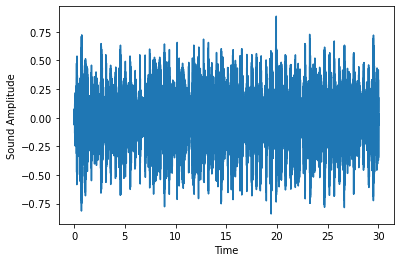

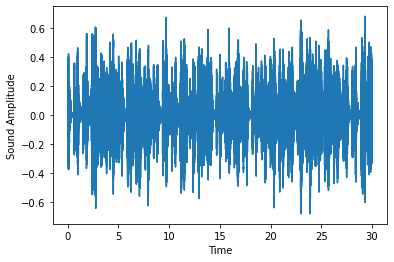

In [57]:
for i in range(2):
    audio, sfreq = librosa.load(filepath+str(i)+".wav")
    time = np.arange(0, len(audio))/sfreq
    plt.plot(time,audio)
    plt.xlabel("Time")
    plt.ylabel("Sound Amplitude")
    plt.show()

# Classifier
This part uses the concepts of ANN with keras and sequential layers. Dataset has been splitted in ratio of 70:30


In [58]:
# load data
def load_data(dataset_path):
    with open(dataset_path,"r") as f:
        data = json.load(f)
    
    # Convert list to numpy arrays
    inputs = np.array(data["mfcc"])
    targets = np.array(data["labels"])    
    
    return inputs,targets

In [59]:
inputs,targets = load_data(r"./data.json")

In [60]:
type(inputs)

numpy.ndarray

In [61]:
type(targets)

numpy.ndarray

In [62]:
input_train, input_test, target_train, target_test = train_test_split(inputs, targets, test_size=0.3)
print(input_train.shape, target_train.shape)

(6990, 130, 13) (6990,)


In [63]:
target_test.shape

(2996,)

In [64]:
model = Sequential()

model.add(Flatten(input_shape=(inputs.shape[1],inputs.shape[2])))
model.add(Dense(512, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(10, activation='softmax'))
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_3 (Flatten)          (None, 1690)              0         
_________________________________________________________________
dense_14 (Dense)             (None, 512)               865792    
_________________________________________________________________
dense_15 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_16 (Dense)             (None, 64)                16448     
_________________________________________________________________
dense_17 (Dense)             (None, 10)                650       
Total params: 1,014,218
Trainable params: 1,014,218
Non-trainable params: 0
_________________________________________________________________


In [65]:
adam = optimizers.Adam(learning_rate=1e-4)

In [66]:
model.compile(optimizer=adam,
             loss="sparse_categorical_crossentropy",
             metrics=["accuracy"])

In [67]:
model.compile(optimizer=adam,
             loss="sparse_categorical_crossentropy",
             metrics=["accuracy"])

hist = model.fit(input_train, target_train,
                 validation_data = (input_test,target_test),
                 epochs = 50,
                 batch_size = 32)

Epoch 1/50
219/219 [==============================] - 3s 10ms/step - loss: 8.9608 - accuracy: 0.3351 - val_loss: 5.0034 - val_accuracy: 0.3575
Epoch 2/50
219/219 [==============================] - 2s 10ms/step - loss: 3.4993 - accuracy: 0.4402 - val_loss: 3.8034 - val_accuracy: 0.3939
Epoch 3/50
219/219 [==============================] - 2s 11ms/step - loss: 2.4839 - accuracy: 0.4976 - val_loss: 3.4117 - val_accuracy: 0.4099
Epoch 4/50
219/219 [==============================] - 2s 11ms/step - loss: 2.0000 - accuracy: 0.5475 - val_loss: 3.0547 - val_accuracy: 0.4332
Epoch 5/50
219/219 [==============================] - 2s 9ms/step - loss: 1.5650 - accuracy: 0.6066 - val_loss: 2.9606 - val_accuracy: 0.4473
Epoch 6/50
219/219 [==============================] - 2s 9ms/step - loss: 1.1931 - accuracy: 0.6694 - val_loss: 2.4933 - val_accuracy: 0.4840
Epoch 7/50
219/219 [==============================] - 2s 9ms/step - loss: 1.0143 - accuracy: 0.7087 - val_loss: 2.5594 - val_accuracy: 0.4750
Ep

In [68]:
def plot_history(hist):
    plt.figure(figsize=(20,15))
    fig, axs = plt.subplots(2)
    # accuracy subplot
    axs[0].plot(hist.history["accuracy"], label="train accuracy")
    axs[0].plot(hist.history["val_accuracy"], label="test accuracy")    
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")
    axs[0].set_title("Accuracy eval")
    
    # Error subplot
    axs[1].plot(hist.history["loss"], label="train error")
    axs[1].plot(hist.history["val_loss"], label="test error")    
    axs[1].set_ylabel("Error")
    axs[1].set_xlabel("Epoch")
    axs[1].legend(loc="upper right")
    axs[1].set_title("Error eval")
    
    plt.show()

<Figure size 1440x1080 with 0 Axes>

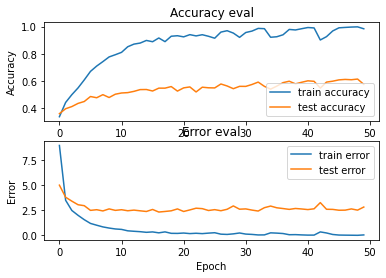

In [69]:
plot_history(hist)

In [70]:
test_error, test_accuracy = model.evaluate(input_test, target_test, verbose=1)
print(f"Test accuracy: {test_accuracy}")

94/94 [==============================] - 0s 4ms/step - loss: 2.8260 - accuracy: 0.5738
Test accuracy: 0.5737650394439697


# Overfitting
This part deals with the overfitting of the previous model. We can deal with it by majorly doing the following process.
- Making architecture less complicated 
- Using augmented data
- Early stopping of training
- Adding dropout layers 


In [73]:
# Overfitting
model = Sequential()

model.add(Flatten(input_shape=(inputs.shape[1],inputs.shape[2])))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(32, activation='relu'))
model.add(Dense(10, activation='softmax'))
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_5 (Flatten)          (None, 1690)              0         
_________________________________________________________________
dense_23 (Dense)             (None, 512)               865792    
_________________________________________________________________
dropout_9 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_24 (Dense)             (None, 256)               131328    
_________________________________________________________________
dropout_10 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_25 (Dense)             (None, 64)                16448     
_________________________________________________________________
dropout_11 (Dropout)         (None, 64)               

In [74]:
model.compile(optimizer=adam,
             loss="sparse_categorical_crossentropy",
             metrics=["accuracy"])

hist = model.fit(input_train, target_train,
                 validation_data = (input_test,target_test),
                 epochs = 100,
                 batch_size = 32)


Epoch 1/100
219/219 [==============================] - 3s 11ms/step - loss: 8.5325 - accuracy: 0.1516 - val_loss: 2.1098 - val_accuracy: 0.2326
Epoch 2/100
219/219 [==============================] - 2s 11ms/step - loss: 2.6156 - accuracy: 0.1873 - val_loss: 2.1070 - val_accuracy: 0.2427
Epoch 3/100
219/219 [==============================] - 2s 11ms/step - loss: 2.3618 - accuracy: 0.2079 - val_loss: 1.9525 - val_accuracy: 0.2870
Epoch 4/100
219/219 [==============================] - 2s 11ms/step - loss: 2.2290 - accuracy: 0.2333 - val_loss: 1.9484 - val_accuracy: 0.2754
Epoch 5/100
219/219 [==============================] - 2s 11ms/step - loss: 2.1086 - accuracy: 0.2589 - val_loss: 1.9055 - val_accuracy: 0.3117
Epoch 6/100
219/219 [==============================] - 2s 11ms/step - loss: 2.0332 - accuracy: 0.2821 - val_loss: 1.8590 - val_accuracy: 0.3214
Epoch 7/100
219/219 [==============================] - 2s 11ms/step - loss: 1.9753 - accuracy: 0.2938 - val_loss: 1.8291 - val_accuracy:

<Figure size 1440x1080 with 0 Axes>

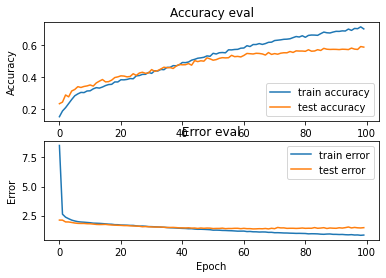

In [75]:
plot_history(hist)

In [76]:
test_error, test_accuracy = model.evaluate(input_test, target_test, verbose=1)
print(f"Test accuracy: {test_accuracy}")

94/94 [==============================] - 0s 3ms/step - loss: 1.4586 - accuracy: 0.5851
Test accuracy: 0.5851134657859802


We can see that the overfitting is greatly reduced but still we are not able to get a good accuracy. Now we will try doing it with Convolutional Neural Network (CNN)

# CNN
Using keras layers of Conv2D, MaxPool2D, BatchNormalization.


In [77]:
def prepare_dataset(test_size, validation_size):
    X,y = load_data(r"./data.json")
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = validation_size)
    X_train = X_train[..., np.newaxis]
    X_val = X_val[..., np.newaxis]
    X_test = X_test[..., np.newaxis]

    return X_train, X_val, X_test, y_train, y_val, y_test

In [78]:
X_train, X_val, X_test, y_train, y_val, y_test = prepare_dataset(0.25, 0.2)

In [79]:
input_shape = (X_train.shape[1],X_train.shape[2],X_train.shape[3])
print(input_shape)

(130, 13, 1)


In [80]:
model = Sequential()
model.add(Conv2D(64, (3, 3), activation = "relu", input_shape = input_shape))
model.add(MaxPool2D((3, 3), strides=(2, 2), padding="same"))
model.add(BatchNormalization())

model.add(Conv2D(32, (3, 3), activation = "relu"))
model.add(MaxPool2D((3, 3), strides=(2, 2), padding="same"))
model.add(BatchNormalization())

model.add(Conv2D(32, (2, 2), activation = "relu"))
model.add(MaxPool2D((2, 2), strides=(2, 2), padding="same"))
model.add(BatchNormalization())

model.add(Conv2D(16, (1, 1), activation = "relu"))
model.add(MaxPool2D((1, 1), strides=(2, 2), padding="same"))
model.add(BatchNormalization())

model.add(Flatten())
model.add(Dense(64, activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(10, activation="softmax"))

model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 11, 64)       640       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 6, 64)         0         
_________________________________________________________________
batch_normalization (BatchNo (None, 64, 6, 64)         256       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 62, 4, 32)         18464     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 2, 32)         0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 31, 2, 32)         128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 30, 1, 32)        

In [81]:
model.compile(optimizer=adam,
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

hist = model.fit(X_train, y_train,
                 validation_data = (X_val, y_val),
                 epochs = 100,
                 batch_size = 32)

Epoch 1/100
188/188 [==============================] - 14s 68ms/step - loss: 2.0809 - accuracy: 0.3088 - val_loss: 1.7840 - val_accuracy: 0.3852
Epoch 2/100
188/188 [==============================] - 13s 68ms/step - loss: 1.6805 - accuracy: 0.4023 - val_loss: 1.4688 - val_accuracy: 0.4499
Epoch 3/100
188/188 [==============================] - 12s 66ms/step - loss: 1.5571 - accuracy: 0.4400 - val_loss: 1.3585 - val_accuracy: 0.4927
Epoch 4/100
188/188 [==============================] - 12s 63ms/step - loss: 1.4596 - accuracy: 0.4639 - val_loss: 1.2645 - val_accuracy: 0.5394
Epoch 5/100
188/188 [==============================] - 12s 63ms/step - loss: 1.3868 - accuracy: 0.4982 - val_loss: 1.2715 - val_accuracy: 0.5260
Epoch 6/100
188/188 [==============================] - 12s 65ms/step - loss: 1.3420 - accuracy: 0.5141 - val_loss: 1.2042 - val_accuracy: 0.5554
Epoch 7/100
188/188 [==============================] - 12s 65ms/step - loss: 1.2857 - accuracy: 0.5361 - val_loss: 1.1482 - val_ac

<Figure size 1440x1080 with 0 Axes>

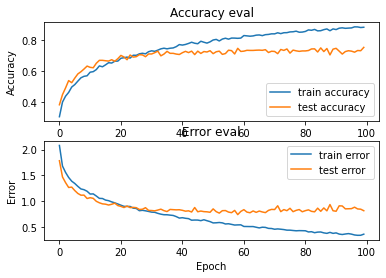

In [82]:
plot_history(hist)

In [83]:
test_error, test_accuracy = model.evaluate(X_test, y_test, verbose=1)
print(f"Test accuracy: {test_accuracy}")

79/79 [==============================] - 1s 15ms/step - loss: 0.7562 - accuracy: 0.7673
Test accuracy: 0.7673208117485046


In [84]:
def predict(model, X, y):
    X = X[np.newaxis,...]
    prediction = model.predict(X)
    predicted_index = np.argmax(prediction, axis=1)
    print(f"Expected index: {y}, Predicted index: {predicted_index}")

In [85]:
predict(model, X_test[10], y_test[10])

Expected index: 7, Predicted index: [7]


## Using the images in dataset with data Augmentation

In [86]:
for dirname, _, filenames in os.walk('./images_original'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

./images_original\blues\blues00000.png
./images_original\blues\blues00001.png
./images_original\blues\blues00002.png
./images_original\blues\blues00003.png
./images_original\blues\blues00004.png
./images_original\blues\blues00005.png
./images_original\blues\blues00006.png
./images_original\blues\blues00007.png
./images_original\blues\blues00008.png
./images_original\blues\blues00009.png
./images_original\blues\blues00010.png
./images_original\blues\blues00011.png
./images_original\blues\blues00012.png
./images_original\blues\blues00013.png
./images_original\blues\blues00014.png
./images_original\blues\blues00015.png
./images_original\blues\blues00016.png
./images_original\blues\blues00017.png
./images_original\blues\blues00018.png
./images_original\blues\blues00019.png
./images_original\blues\blues00020.png
./images_original\blues\blues00021.png
./images_original\blues\blues00022.png
./images_original\blues\blues00023.png
./images_original\blues\blues00024.png
./images_original\blues\b

In [87]:
splitfolders.ratio('./images_original/',output='trainandtest',ratio=(0.8,0.2),group_prefix=None)

In [88]:
train_datagen=ImageDataGenerator(rescale=1./255,
                                shear_range=0.2,
                                zoom_range=0.2,
                                horizontal_flip=True)

In [89]:
test_datagen=ImageDataGenerator(rescale=1./255)

In [90]:
training_set=train_datagen.flow_from_directory('./trainandtest/train',
                                              target_size=(32,32),
                                              batch_size=1024,
                                              class_mode='categorical')

Found 799 images belonging to 10 classes.


In [91]:
testing_set=test_datagen.flow_from_directory('./trainandtest/val',
                                              target_size=(32,32),
                                              batch_size=1024,
                                              class_mode='categorical')

Found 300 images belonging to 10 classes.


In [92]:
model = Sequential()
model.add(Conv2D(64, (3, 3), activation = "relu", input_shape = (32,32,3)))
model.add(MaxPool2D((3, 3), strides=(2, 2), padding="same"))
model.add(BatchNormalization())

model.add(Conv2D(32, (3, 3), activation = "relu"))
model.add(MaxPool2D((3, 3), strides=(2, 2), padding="same"))
model.add(BatchNormalization())

model.add(Conv2D(32, (2, 2), activation = "relu"))
model.add(MaxPool2D((2, 2), strides=(2, 2), padding="same"))
model.add(BatchNormalization())

model.add(Conv2D(16, (1, 1), activation = "relu"))
model.add(MaxPool2D((1, 1), strides=(2, 2), padding="same"))
model.add(BatchNormalization())

model.add(Flatten())
model.add(Dense(64, activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(10, activation="softmax"))

model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 30, 30, 64)        1792      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 15, 15, 64)        0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 15, 15, 64)        256       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 13, 13, 32)        18464     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 7, 7, 32)          128       
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 6, 6, 32)         

In [93]:
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [94]:
model.fit(training_set,
                        epochs=100,validation_data=testing_set)

Epoch 1/100
1/1 [==============================] - 7s 7s/step - loss: 2.8098 - accuracy: 0.0776 - val_loss: 2.3050 - val_accuracy: 0.1000
Epoch 2/100
1/1 [==============================] - 3s 3s/step - loss: 2.6002 - accuracy: 0.1014 - val_loss: 2.3045 - val_accuracy: 0.1067
Epoch 3/100
1/1 [==============================] - 4s 4s/step - loss: 2.4865 - accuracy: 0.1176 - val_loss: 2.3049 - val_accuracy: 0.0800
Epoch 4/100
1/1 [==============================] - 3s 3s/step - loss: 2.4372 - accuracy: 0.1164 - val_loss: 2.3053 - val_accuracy: 0.0833
Epoch 5/100
1/1 [==============================] - 4s 4s/step - loss: 2.4258 - accuracy: 0.1126 - val_loss: 2.3055 - val_accuracy: 0.0900
Epoch 6/100
1/1 [==============================] - 4s 4s/step - loss: 2.4114 - accuracy: 0.1139 - val_loss: 2.3053 - val_accuracy: 0.0767
Epoch 7/100
1/1 [==============================] - 4s 4s/step - loss: 2.3153 - accuracy: 0.1677 - val_loss: 2.3051 - val_accuracy: 0.0733
Epoch 8/100
1/1 [=================

1/1 [==============================] - 3s 3s/step - loss: 1.7040 - accuracy: 0.3605 - val_loss: 2.3476 - val_accuracy: 0.1000
Epoch 61/100
1/1 [==============================] - 3s 3s/step - loss: 1.6957 - accuracy: 0.3830 - val_loss: 2.3507 - val_accuracy: 0.1000
Epoch 62/100
1/1 [==============================] - 3s 3s/step - loss: 1.6775 - accuracy: 0.4093 - val_loss: 2.3541 - val_accuracy: 0.1000
Epoch 63/100
1/1 [==============================] - 3s 3s/step - loss: 1.6880 - accuracy: 0.4018 - val_loss: 2.3570 - val_accuracy: 0.1000
Epoch 64/100
1/1 [==============================] - 4s 4s/step - loss: 1.6362 - accuracy: 0.4180 - val_loss: 2.3596 - val_accuracy: 0.1000
Epoch 65/100
1/1 [==============================] - 4s 4s/step - loss: 1.6586 - accuracy: 0.4105 - val_loss: 2.3620 - val_accuracy: 0.1000
Epoch 66/100
1/1 [==============================] - 3s 3s/step - loss: 1.6517 - accuracy: 0.4155 - val_loss: 2.3652 - val_accuracy: 0.1000
Epoch 67/100
1/1 [======================

# Transfer Learning Model

In [95]:
base_model = VGG19(weights='imagenet',include_top=False,input_shape=(32,32,3))

In [96]:
base_model.trainable=False
base_model.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0     

In [97]:
transfer_model=Sequential([base_model,
                          GlobalAveragePooling2D(),
                          Dense(512,activation='relu'),
                          Dense(10,activation='softmax')])
transfer_model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 1, 1, 512)         20024384  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dense_32 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_33 (Dense)             (None, 10)                5130      
Total params: 20,292,170
Trainable params: 267,786
Non-trainable params: 20,024,384
_________________________________________________________________


In [98]:
transfer_model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [99]:
transfer_model.fit(training_set,
                            epochs=100,
                            validation_data=testing_set)

Epoch 1/100
1/1 [==============================] - 10s 10s/step - loss: 2.4632 - accuracy: 0.0939 - val_loss: 2.3178 - val_accuracy: 0.1167
Epoch 2/100
1/1 [==============================] - 7s 7s/step - loss: 2.3082 - accuracy: 0.1464 - val_loss: 2.2887 - val_accuracy: 0.1267
Epoch 3/100
1/1 [==============================] - 7s 7s/step - loss: 2.2772 - accuracy: 0.1527 - val_loss: 2.2939 - val_accuracy: 0.1433
Epoch 4/100
1/1 [==============================] - 7s 7s/step - loss: 2.2902 - accuracy: 0.1377 - val_loss: 2.2845 - val_accuracy: 0.1133
Epoch 5/100
1/1 [==============================] - 7s 7s/step - loss: 2.2872 - accuracy: 0.1189 - val_loss: 2.2515 - val_accuracy: 0.1667
Epoch 6/100
1/1 [==============================] - 7s 7s/step - loss: 2.2432 - accuracy: 0.1427 - val_loss: 2.2171 - val_accuracy: 0.2633
Epoch 7/100
1/1 [==============================] - 7s 7s/step - loss: 2.2118 - accuracy: 0.2003 - val_loss: 2.1947 - val_accuracy: 0.2633
Epoch 8/100
1/1 [===============

Epoch 60/100
1/1 [==============================] - 7s 7s/step - loss: 1.8099 - accuracy: 0.3492 - val_loss: 1.8490 - val_accuracy: 0.3600
Epoch 61/100
1/1 [==============================] - 7s 7s/step - loss: 1.8100 - accuracy: 0.3592 - val_loss: 1.8499 - val_accuracy: 0.3567
Epoch 62/100
1/1 [==============================] - 7s 7s/step - loss: 1.8144 - accuracy: 0.3667 - val_loss: 1.8480 - val_accuracy: 0.3600
Epoch 63/100
1/1 [==============================] - 7s 7s/step - loss: 1.7861 - accuracy: 0.3680 - val_loss: 1.8433 - val_accuracy: 0.3600
Epoch 64/100
1/1 [==============================] - 7s 7s/step - loss: 1.7929 - accuracy: 0.3780 - val_loss: 1.8369 - val_accuracy: 0.3600
Epoch 65/100
1/1 [==============================] - 8s 8s/step - loss: 1.7899 - accuracy: 0.3630 - val_loss: 1.8329 - val_accuracy: 0.3633
Epoch 66/100
1/1 [==============================] - 8s 8s/step - loss: 1.7880 - accuracy: 0.3554 - val_loss: 1.8313 - val_accuracy: 0.3633
Epoch 67/100
1/1 [=========

Mel-spectrograms are visual, and CNNs work better with pictures. The CNN performed the best, as we expected. It took the longest time to train as well, but the increase in accuracy justifies the extra computation cost.